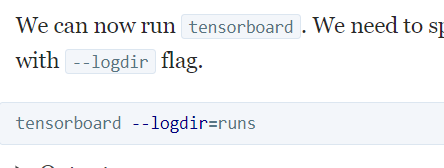

### 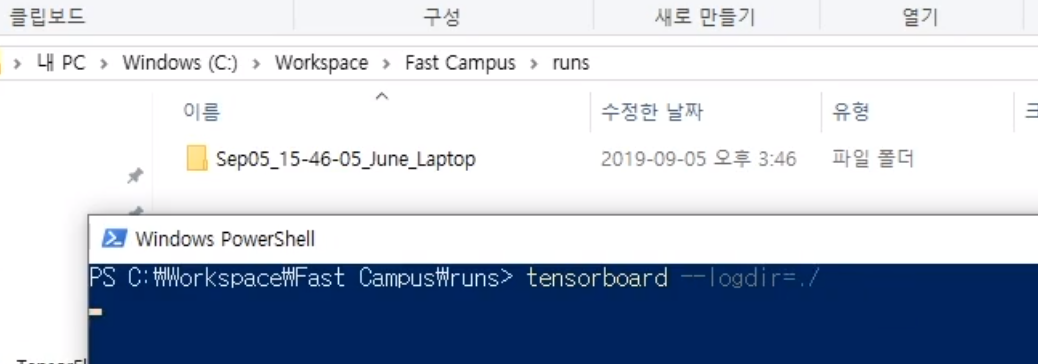

In [1]:
import os
from glob import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from torch.utils.data import Dataset, DataLoader

import numpy as np
from PIL import Image

In [2]:
seed = 1

lr = 0.001
momentum = 0.5

batch_size = 64
test_batch_size = 64

epochs = 4
no_cuda = False
log_interval = 100

# Model

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Preprocess

In [4]:
train_paths = glob('dataset/mnist_png/training/*/*.png')[:1000]
test_paths = glob('dataset/mnist_png/testing/*/*.png')[:1000]

len(train_paths), len(test_paths)

(1000, 1000)

참고: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class

In [5]:
class Dataset(Dataset):
    def __init__(self, data_paths, transform=None):

        self.data_paths = data_paths
        self.transform = transform

    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, idx):
        path = self.data_paths[idx]
        image = Image.open(path).convert("L")
        label = int(path.split('\\')[-2])
        
        if self.transform:
            image = self.transform(image)

        return image, label

In [6]:
torch.manual_seed(seed)

use_cuda = not no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(
    Dataset(train_paths, 
            transforms.Compose([
                transforms.RandomHorizontalFlip(), 
                transforms.ToTensor(), 
                transforms.Normalize(
                    mean=[0.406], 
                    std=[0.225])])
           ),
    batch_size=batch_size, 
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    Dataset(test_paths,
           transforms.Compose([
               transforms.ToTensor(), 
               transforms.Normalize(
                   mean=[0.406], 
                   std=[0.225])])
           ),
    batch_size=batch_size, 
    shuffle=False,
)

In [7]:
for i, data in enumerate(train_loader):
    if i == 0:
        print(data[0].shape, data[1].shape)
        break

torch.Size([64, 1, 28, 28]) torch.Size([64])


In [8]:
for i, data in enumerate(test_loader):
    if i == 0:
        print(data[0].shape, data[1].shape)
        break

torch.Size([64, 1, 28, 28]) torch.Size([64])


# Optimization

In [9]:
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training

In [11]:
import torchvision
from torch.utils.tensorboard import SummaryWriter
#from tensorboardX import SummaryWriter

ModuleNotFoundError: No module named 'torch.utils.tensorboard'

In [ ]:
writer = SummaryWriter()  # logdir을 지정해주지 않아도 자동으로 생성

In [ ]:
for epoch in range(1, epochs + 1):
    # Train Mode
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)  # https://pytorch.org/docs/stable/nn.html#nll-loss
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    
    # Test mode
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    
    accuracy = 100. * correct / len(test_loader.dataset)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))
    
    
    # Add to TensorBoard
    grid = torchvision.utils.make_grid(data) # image를 넣어 줄 grid
    writer.add_image('images', grid, epoch)
    writer.add_graph(model, data)
    
    writer.add_scalar('Loss/train', loss, epoch) # 숫자 1
    writer.add_scalar('Loss/test', test_loss, epoch)  # 숫자 2
    writer.add_scalar('Accuracy/test', accuracy, epoch) # 숫자 3
    
writer.close()